<a href="https://colab.research.google.com/github/Amber-cpu33/sharepoint/blob/main/Convenient_store_analysis_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 資料準備

In [1]:
! pip install xgboost

In [2]:
# 1. 下載中文字體 (Noto Sans TC)
!wget -O font.ttf https://github.com/googlefonts/noto-cjk/raw/main/Sans/OTF/TraditionalChinese/NotoSansCJKtc-Regular.otf

# 2. 引入字體庫
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 3. 設定字體屬性
custom_font = fm.FontProperties(fname='font.ttf')

# 測試：如果這行沒出現方框，代表成功
# plt.text(0.5, 0.5, '測試中文字體：成功', fontproperties=custom_font)
# plt.show()

--2026-02-27 04:43:28--  https://github.com/googlefonts/noto-cjk/raw/main/Sans/OTF/TraditionalChinese/NotoSansCJKtc-Regular.otf
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/notofonts/noto-cjk/raw/main/Sans/OTF/TraditionalChinese/NotoSansCJKtc-Regular.otf [following]
--2026-02-27 04:43:28--  https://github.com/notofonts/noto-cjk/raw/main/Sans/OTF/TraditionalChinese/NotoSansCJKtc-Regular.otf
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/notofonts/noto-cjk/main/Sans/OTF/TraditionalChinese/NotoSansCJKtc-Regular.otf [following]
--2026-02-27 04:43:29--  https://raw.githubusercontent.com/notofonts/noto-cjk/main/Sans/OTF/TraditionalChinese/NotoSansCJKtc-Regular.otf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

In [9]:
df = pd.read_csv('train_data_v1.1.csv', encoding='utf-8', index_col=False)
df = df.dropna()
df_test = pd.read_csv('test_data_v1.1.csv', encoding='utf-8', index_col=False)
df_test = df_test.dropna()

In [10]:
df.columns

Index(['id', '公司名稱', '縣市', '行政區', '里別', '行政區平日夜間停留人數', '行政區平日日間活動人數',
       '行政區假日夜間停留人數', '行政區假日日間活動人數', '里人均收入中位數', '里人口數', '發票張數指標', '發票銷售額指標',
       '500公尺內的熱鬧據點數', '最近的熱鬧據點類型', '最近的熱鬧據點距離', '500公尺內部競爭(同公司店數)',
       '500公尺外部競爭(不同公司店數)', '租金', '競爭壓力指標', '生存難度', '競爭優勢', '是否便利商店',
       'people_per_store', 'day_night_flow', '登記現況'],
      dtype='object')

In [37]:
df.groupby('公司名稱').size().sort_values(ascending=False)

,0
公司名稱,
統一超商股份有限公司,2417
全家便利商店股份有限公司,1672
萊爾富國際股份有限公司,689
三商家購股份有限公司,386
來來超商股份有限公司,376
全聯實業股份有限公司,342
台灣屈臣氏個人用品商店股份有限公司,272
統一生活事業股份有限公司,214
家福股份有限公司,59


In [39]:
df.groupby('是否便利商店').size().sort_values(ascending=False)

,0
是否便利商店,
1,5154
0,1273


# XGBOOST模型訓練

In [11]:
# ==========================================
# 1. 資料篩選與目標變數定義
# ==========================================
# 僅保留「營運中」與「廢止」作為分類基底
df_ml = df[df['登記現況'].isin(['營運中', '廢止'])].copy()
df_ml['target'] = df_ml['登記現況'].map({'營運中': 1, '廢止': 0})

In [12]:
# ==========================================
# 2. 特徵工程 (13 特徵黃金清單)
# ==========================================
# A. 計算數值型特徵轉換
df_ml['日夜人流差'] = df_ml['行政區平日日間活動人數'] - df_ml['行政區平日夜間停留人數']
df_ml['租金_log'] = np.log1p(df_ml['租金'])
df_ml['最近的熱鬧據點類型'] = df_ml['最近的熱鬧據點類型'].astype('category')

# # B. 處理類別型特徵 (XGBoost 專用類別型態)
# category_cols = ['最近的熱鬧據點類型', '是否便利商店'] # 是否便利商店雖是0/1也可轉為類別
# for col in category_cols:
#     if col in df_ml.columns:
#         df_ml[col] = df_ml[col].astype('category')
# 定義最終特徵欄位
final_features = [
    '是否便利商店', '競爭優勢', 'people_per_store', '競爭壓力指標',
    '里人均收入中位數', '發票銷售額指標',
    '行政區平日日間活動人數', '日夜人流差', # <-- 替換夜間 raw data
    '最近的熱鬧據點類型', '最近的熱鬧據點距離',
    '租金_log', '里人口數', '發票張數指標'
]

In [13]:
# ==========================================
# 3. 資料集切分 (Train 90% / Val 10%)
# ==========================================
X = df_ml[final_features]
y = df_ml['target']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# 轉換為 XGBoost 專用 DMatrix (啟用類別特徵支援)
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

In [14]:
# ==========================================
# 4. 模型參數與訓練
# ==========================================
params = {
    'objective': 'binary:logistic',
    'max_depth': 4,
    'eta': 0.05,
    'gamma': 1.2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 0.4, # 調整正負樣本權重
    'eval_metric': 'logloss',
    'random_state': 42
}

final_model = xgb.train(params, dtrain, num_boost_round=150)

In [15]:
# ==========================================
# 5. 雙軌門檻預測邏輯
# ==========================================
y_prob = final_model.predict(dval)
y_pred = []

# 提取驗證集中的便利商店標記 (用於門檻判斷)
is_cvs_val = X_val['是否便利商店'].values

for i in range(len(y_prob)):
    # 邏輯：便利商店門檻較寬(0.5)，一般店面較嚴格(0.7)
    threshold = 0.5 if is_cvs_val[i] == 1 else 0.7
    y_pred.append(1 if y_prob[i] >= threshold else 0)

y_pred = np.array(y_pred)

In [16]:
# ==========================================
# 6. 驗證集結果
# ==========================================
print("--- 🏆 13 特徵最終版 - 驗證集表現 ---")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print("\n詳細分類報告:")
print(classification_report(y_val, y_pred))

--- 🏆 13 特徵最終版 - 驗證集表現 ---
Accuracy: 0.6143

詳細分類報告:
              precision    recall  f1-score   support

           0       0.39      0.60      0.47       186
           1       0.79      0.62      0.70       457

    accuracy                           0.61       643
   macro avg       0.59      0.61      0.58       643
weighted avg       0.68      0.61      0.63       643



In [17]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score, precision_score

def evaluate_master(model, X_val_df, y_val_true):
    """
    針對 13 特徵戰略版設計的自動對齊評估函數
    功能：
    1. 自動對齊模型特徵順序 (避免 Feature Name Mismatch)
    2. 執行分組動態門檻判定
    3. 產出商業導向的評估報表
    """
    # 1. 特徵對齊：直接從 model.feature_names 獲取，確保預測時欄位順序與訓練時完全一致
    model_features = model.feature_names

    # 檢查驗證集中是否缺少必要欄位
    missing_cols = set(model_features) - set(X_val_df.columns)
    if missing_cols:
        raise ValueError(f"驗證集中缺少以下特徵: {missing_cols}")

    # 2. 執行預測
    dval = xgb.DMatrix(X_val_df[model_features], enable_categorical=True)
    y_prob = model.predict(dval)

    # 3. 雙軌動態門檻邏輯 (CVS 寬鬆 0.5 / 一般 嚴格 0.7)
    # 使用 np.where 加速處理邏輯
    is_cvs = X_val_df['是否便利商店'].astype(int).values
    thresholds = np.where(is_cvs == 1, 0.5, 0.7)
    y_pred = (y_prob >= thresholds).astype(int)

    # 4. 輸出視覺化診斷報告
    print("\n" + "═"*65)
    print(" 🏆  13 特徵戰略版：店址模型最終評估報告 ".center(60))
    print("═"*65)

    groups = [
        (0, "🏠 連鎖超市/藥妝組 (門檻 0.7)"),
        (1, "🏪 便利商店組 CVS (門檻 0.5)")
    ]

    for g_val, g_name in groups:
        mask = (X_val_df['是否便利商店'].astype(int) == g_val)

        if mask.any():
            y_t = y_val_true[mask]
            y_p = y_pred[mask]

            print(f"\n▶ {g_name}")
            print(f"   ● 總樣本數         : {len(y_t)}")
            print(f"   ● Accuracy  (準確率) : {accuracy_score(y_t, y_p):.2%}")
            print(f"   ● Recall 0  (風險捕捉) : {recall_score(y_t, y_p, pos_label=0):.2%}")
            print(f"   ● Precision 1 (推薦信心) : {precision_score(y_t, y_p, pos_label=1):.2%}")

            # 計算 F1-score 衡量平衡性
            p1 = precision_score(y_t, y_p, pos_label=1)
            r1 = recall_score(y_t, y_p, pos_label=1)
            f1 = 2 * (p1 * r1) / (p1 + r1) if (p1 + r1) > 0 else 0
            print(f"   ● F1-Score  (綜合指標) : {f1:.4f}")

    print("\n" + "═"*65)

    # 全體加總評估
    print(f"⭐ 全體總準確率 (Overall Accuracy): {accuracy_score(y_val_true, y_pred):.2%}")
    print("═"*65)

    return y_pred, y_prob

# --- 執行評估 ---
y_val_pred, y_val_prob = evaluate_master(final_model, X_val, y_val)


═════════════════════════════════════════════════════════════════
                   🏆  13 特徵戰略版：店址模型最終評估報告                   
═════════════════════════════════════════════════════════════════

▶ 🏠 連鎖超市/藥妝組 (門檻 0.7)
   ● 總樣本數         : 119
   ● Accuracy  (準確率) : 65.55%
   ● Recall 0  (風險捕捉) : 52.63%
   ● Precision 1 (推薦信心) : 88.31%
   ● F1-Score  (綜合指標) : 0.7684

▶ 🏪 便利商店組 CVS (門檻 0.5)
   ● 總樣本數         : 524
   ● Accuracy  (準確率) : 60.50%
   ● Recall 0  (風險捕捉) : 61.08%
   ● Precision 1 (推薦信心) : 76.79%
   ● F1-Score  (綜合指標) : 0.6750

═════════════════════════════════════════════════════════════════
⭐ 全體總準確率 (Overall Accuracy): 61.43%
═════════════════════════════════════════════════════════════════


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 21542 (\N{CJK UNIFIED IDEOGRAPH-5426}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 20415 (\N{CJK UNIFIED IDEOGRAPH-4FBF}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 21033 (\N{CJK UNIFIED IDEOGRAPH-5229}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 21830 (\N{CJK UNIFIED IDEOGRAPH-5546}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 24215 (\N{CJK UNIFIED IDEOGRAPH-5E97}) missing from fon

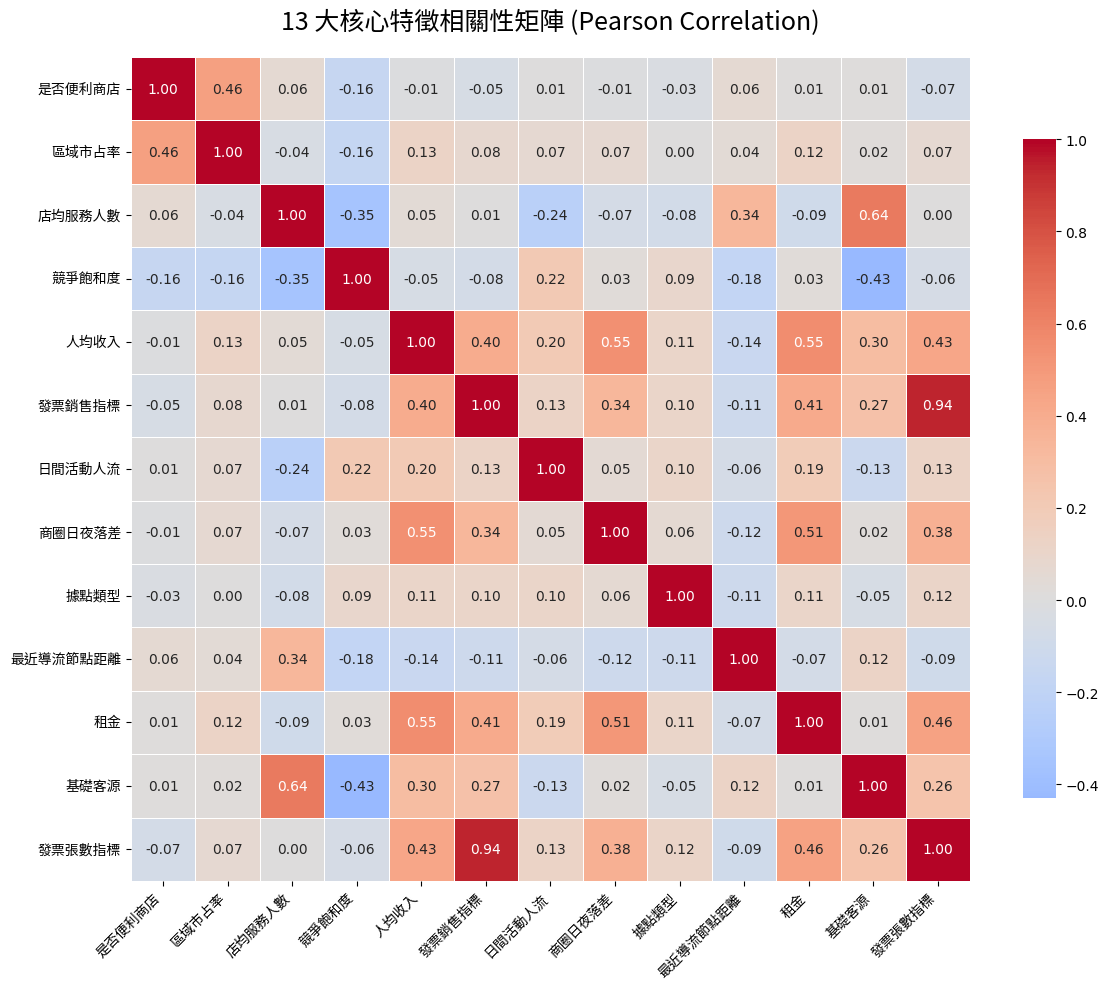

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

X_train_corr = X_train.copy()
for col in X_train_corr.select_dtypes(['category']).columns:
    X_train_corr[col] = X_train_corr[col].cat.codes

corr_matrix = X_train_corr.corr()

# Redefining name_map to ensure it is available in this scope
name_map = {
    '競爭優勢': '區域市占率',
    'people_per_store': '店均服務人數',
    '競爭壓力指標': '競爭飽和度',
    '最近的熱鬧據點距離': '最近導流節點距離',
    '發票張數指標': '發票張數指標',
    '租金_log': '租金',
    '里人均收入中位數': '人均收入',
    '里人口數': '基礎客源',
    '日夜人流差': '商圈日夜落差',
    '發票銷售額指標': '發票銷售指標',
    '行政區平日日間活動人數': '日間活動人流',
    '是否便利商店': '是否便利商店',
    '最近的熱鬧據點類型': '據點類型'
}

# 1. Rename columns and index using the name_map for visualization
readable_names = [name_map.get(col, col) for col in corr_matrix.columns]
plot_corr = corr_matrix.copy()
plot_corr.columns = readable_names
plot_corr.index = readable_names

# 2. Create the figure
plt.figure(figsize=(12, 10))

# 3. Generate heatmap
ax = sns.heatmap(plot_corr,
                 annot=True,
                 fmt='.2f',
                 cmap='coolwarm',
                 center=0,
                 linewidths=.5,
                 cbar_kws={'shrink': .8})

# 4. Apply custom_font to title and axes
plt.title('13 大核心特徵相關性矩陣 (Pearson Correlation)', fontproperties=custom_font, fontsize=18, pad=20)

# Apply font to X and Y axis tick labels
ax.set_xticklabels(readable_names, fontproperties=custom_font, fontsize=10, rotation=45, ha='right')
ax.set_yticklabels(readable_names, fontproperties=custom_font, fontsize=10, rotation=0)

plt.tight_layout()
plt.show()

# 模型測試

In [19]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 715 non-null    int64  
 1   公司名稱               715 non-null    object 
 2   縣市                 715 non-null    object 
 3   行政區                715 non-null    object 
 4   里別                 715 non-null    object 
 5   行政區平日夜間停留人數        715 non-null    int64  
 6   行政區平日日間活動人數        715 non-null    int64  
 7   行政區假日夜間停留人數        715 non-null    int64  
 8   行政區假日日間活動人數        715 non-null    int64  
 9   里人均收入中位數           715 non-null    int64  
 10  里人口數               715 non-null    int64  
 11  發票張數指標             715 non-null    float64
 12  發票銷售額指標            715 non-null    float64
 13  500公尺內的熱鬧據點數       715 non-null    float64
 14  最近的熱鬧據點類型          715 non-null    object 
 15  最近的熱鬧據點距離          715 non-null    float64
 16  500公尺內部競爭(同公司店數)   715 non

In [20]:
import pandas as pd
import numpy as np
import xgboost as xgb

# 1. 讀取測試集並進行基礎預處理
df_test_ml = df_test.copy()

# 2. 基礎特徵工程 (需與訓練時完全一致)
# 建立 target 並計算衍伸欄位
df_test_ml['target'] = df_test_ml['登記現況'].map({'營運中': 1, '廢止': 0})
df_test_ml['日夜人流差'] = df_test_ml['行政區平日日間活動人數'] - df_test_ml['行政區平日夜間停留人數']
df_test_ml['租金_log'] = np.log1p(df_test_ml['租金'])

# 3. 強制型態對齊 (解決 XGBoost 報錯的終極方案)
# 我們不再手動猜測，而是直接讓測試集的型態「複製」訓練集的型態
for col in final_model.feature_names:
    # 取得模型訓練時該欄位的資料型態
    target_dtype = X_train[col].dtype

    if pd.api.types.is_categorical_dtype(target_dtype):
        # 如果訓練集是類別型，測試集也必須轉為 category
        df_test_ml[col] = df_test_ml[col].astype('category')
    else:
        # 如果訓練集是數值型，確保測試集不會有 object 型態
        df_test_ml[col] = pd.to_numeric(df_test_ml[col], errors='coerce')

# 4. 提取 X 與 y (嚴格遵循模型特徵順序)
X_final_test = df_test_ml[final_model.feature_names]
y_final_test = df_test_ml['target']

# 5. 執行預測
# 建立 DMatrix 並啟用類別支援
dtest_final = xgb.DMatrix(X_final_test, label=y_final_test, enable_categorical=True)
y_test_prob = final_model.predict(dtest_final)

print("✅ 預測成功！")

# 6. 建立決策報表
df_report = X_final_test.copy()
df_report['id'] = df_test_ml['id'].values # 確保帶上 ID 供後續合併
df_report['營運推薦機率'] = y_test_prob
df_report['營運推薦分數'] = y_test_prob * 100

# 雙軌動態門檻邏輯 (CVS=0.5 / 一般=0.7)
def get_decision(row):
    prob = row['營運推薦機率']
    threshold = 0.5 if int(row['是否便利商店']) == 1 else 0.7
    return "優質位點 (推薦展店)" if prob >= threshold else "高風險位點 (建議迴避)"

df_report['專題最終決策'] = df_report.apply(get_decision, axis=1)

# 7. 合併 Metadata (行政區、里別、登記現況)
# 修正重點：
# 1. 改用 'on=id' 合併，不再用 Index
# 2. 對 metadata 先做去重，確保一對一關聯，徹底解決 8000 筆重複問題
metadata_cols = ['id', '行政區', '里別', '登記現況']
df_meta_clean = df_ml[metadata_cols].drop_duplicates(subset=['id'])

df_final_output = df_report.merge(df_meta_clean, on='id', how='left')

# 8. 輸出報告與評估
print(f"最終報表筆數: {len(df_final_output)} (預期應為 715 筆)")
# df_final_output.to_csv('測試集_最終決策報告_修正版.csv', index=False, encoding='utf-8-sig')

print("\n🚩 [獨立測試集 OOS 評估報告]")
# 呼叫既有的評估函數
y_test_pred, y_test_prob = evaluate_master(final_model, X_final_test, y_final_test)

✅ 預測成功！
最終報表筆數: 715 (預期應為 715 筆)

🚩 [獨立測試集 OOS 評估報告]

═════════════════════════════════════════════════════════════════
                   🏆  13 特徵戰略版：店址模型最終評估報告                   
═════════════════════════════════════════════════════════════════

▶ 🏠 連鎖超市/藥妝組 (門檻 0.7)
   ● 總樣本數         : 134
   ● Accuracy  (準確率) : 61.19%
   ● Recall 0  (風險捕捉) : 63.16%
   ● Precision 1 (推薦信心) : 90.91%
   ● F1-Score  (綜合指標) : 0.7292

▶ 🏪 便利商店組 CVS (門檻 0.5)
   ● 總樣本數         : 581
   ● Accuracy  (準確率) : 57.31%
   ● Recall 0  (風險捕捉) : 61.70%
   ● Precision 1 (推薦信心) : 75.09%
   ● F1-Score  (綜合指標) : 0.6364

═════════════════════════════════════════════════════════════════
⭐ 全體總準確率 (Overall Accuracy): 58.04%
═════════════════════════════════════════════════════════════════


/tmp/ipython-input-547/2661690148.py:20: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(target_dtype):
/tmp/ipython-input-547/2661690148.py:20: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(target_dtype):


In [21]:
print("--- 🏆 13 特徵最終版 - 測試集表現 ---")
print(f"Accuracy: {accuracy_score(y_final_test, y_test_pred):.4f}")
print("\n詳細分類報告:")
print(classification_report(y_final_test, y_test_pred, target_names=['廢止 (0)', '營運中 (1)']))

--- 🏆 13 特徵最終版 - 測試集表現 ---
Accuracy: 0.5804

詳細分類報告:
              precision    recall  f1-score   support

      廢止 (0)       0.37      0.62      0.46       207
     營運中 (1)       0.78      0.56      0.66       508

    accuracy                           0.58       715
   macro avg       0.58      0.59      0.56       715
weighted avg       0.66      0.58      0.60       715



In [22]:
from sklearn.metrics import roc_auc_score

# Calculate AUC for the test set using predicted probabilities
test_auc = roc_auc_score(y_final_test, y_test_prob)

print(f"--- Đ† 指標戰略版 --- ")
print(f"獨立測試集 AUC 分數: {test_auc:.4f}")

--- Đ† 指標戰略版 --- 
獨立測試集 AUC 分數: 0.6734


# 計算SHAP

In [23]:
import numpy as np
import pandas as pd
import shap

# 1. 準備資料與計算 SHAP
model_features = final_model.feature_names
X_total = pd.concat([X_train[model_features],
                     X_val[model_features],
                     X_final_test[model_features]], axis=0).copy()

# 類別型轉碼以利計算
X_total_shap = X_total.copy()
for col in X_total_shap.select_dtypes(['category']).columns:
    X_total_shap[col] = X_total_shap[col].cat.codes

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_total_shap)
shap_v = shap_values[1] if isinstance(shap_values, list) else shap_values

# 2. 自動判定正負向邏輯
analysis_data = []
for i, col in enumerate(model_features):
    importance = np.abs(shap_v[:, i]).mean()
    # 計算特徵值與其 SHAP 值的相關係數來判定方向
    correlation = np.corrcoef(X_total_shap[col], shap_v[:, i])[0, 1]
    direction = "(+)" if correlation > 0 else "(-)"
    analysis_data.append({'Feature': col, 'Direction': direction, 'Importance': importance})

# 3. 排序並輸出格式化報告
importance_df = pd.DataFrame(analysis_data).sort_values(by='Importance', ascending=False)

print("\n" + "█"*75)
print(f"📊 {len(model_features)} 大核心特徵：全量影響力排名 (依據 SHAP Value)")
print("  (註：(+) 代表正向貢獻，(-) 代表負向拉力)")
print("█"*75)

for i, (idx, row) in enumerate(importance_df.iterrows(), 1):
    # 調整間距確保對齊
    print(f"第 {i:2d} 名 | {row['Feature']:<25} | {row['Direction']} | 影響權重: {row['Importance']:.4f}")

print("█"*75)


███████████████████████████████████████████████████████████████████████████
📊 13 大核心特徵：全量影響力排名 (依據 SHAP Value)
  (註：(+) 代表正向貢獻，(-) 代表負向拉力)
███████████████████████████████████████████████████████████████████████████
第  1 名 | 是否便利商店                    | (-) | 影響權重: 0.2982
第  2 名 | 競爭優勢                      | (+) | 影響權重: 0.2591
第  3 名 | people_per_store          | (+) | 影響權重: 0.1144
第  4 名 | 競爭壓力指標                    | (-) | 影響權重: 0.0993
第  5 名 | 最近的熱鬧據點距離                 | (+) | 影響權重: 0.0980
第  6 名 | 發票張數指標                    | (+) | 影響權重: 0.0708
第  7 名 | 租金_log                    | (-) | 影響權重: 0.0703
第  8 名 | 里人均收入中位數                  | (-) | 影響權重: 0.0655
第  9 名 | 里人口數                      | (+) | 影響權重: 0.0528
第 10 名 | 日夜人流差                     | (-) | 影響權重: 0.0444
第 11 名 | 發票銷售額指標                   | (+) | 影響權重: 0.0439
第 12 名 | 行政區平日日間活動人數               | (-) | 影響權重: 0.0393
第 13 名 | 最近的熱鬧據點類型                 | (+) | 影響權重: 0.0258
████████████████████████████████████████████████████████

/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 36817 (\N{CJK UNIFIED IDEOGRAPH-8FD1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 29105 (\N{CJK UNIFIED IDEOGRAPH-71B1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 39719 (\N{CJK UNIFIED IDEOGRAPH-9B27}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Gl

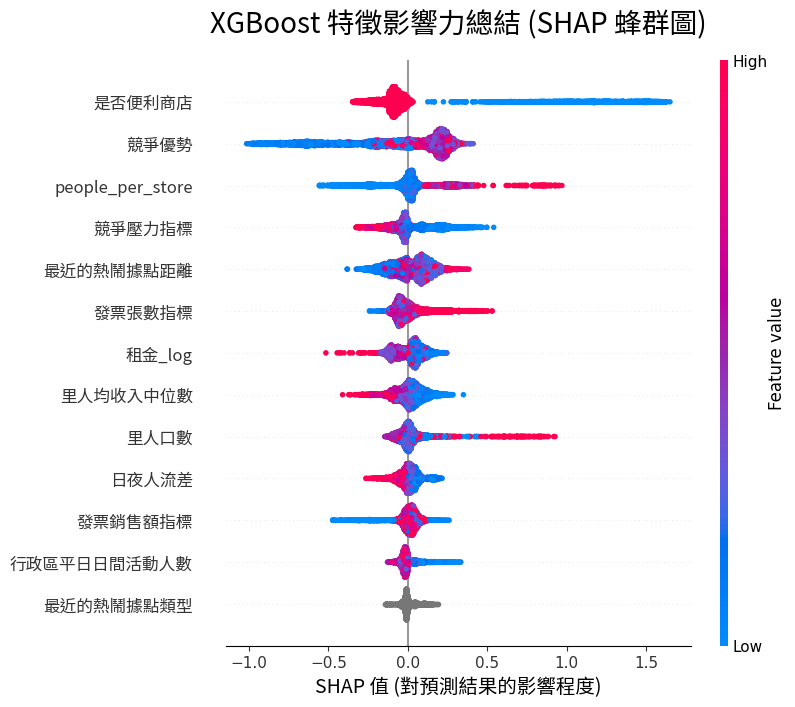

In [24]:
# ==========================================
# 2. 繪製中文化 SHAP Summary Plot
# ==========================================
plt.figure(figsize=(12, 8))

# 繪製蜂群圖
shap.summary_plot(shap_values, X_total, feature_names=final_features, show=False)

# --- 關鍵：套用中文字體到圖表元素 ---
# 獲取目前的座標軸
ax = plt.gca()

# 設定標題 (使用你裝好的 custom_font)
ax.set_title("XGBoost 特徵影響力總結 (SHAP 蜂群圖)", fontproperties=custom_font, fontsize=20, pad=20)

# 設定 X 軸標籤
ax.set_xlabel("SHAP 值 (對預測結果的影響程度)", fontproperties=custom_font, fontsize=14)

# 設定 Y 軸特徵名稱標籤
for label in ax.get_yticklabels():
    label.set_fontproperties(custom_font)
    label.set_fontsize(12)

plt.show()

In [25]:
import numpy as np
import pandas as pd
import pickle

# ==========================================
# 1. 建立 Metadata (加入 ID 欄位)
# ==========================================
# 假設你的 ID 欄位名稱就叫 'ID'，請根據實際情況修改 (例如 '統一編號' 或 '店號')
id_col = 'id'

df_combined_meta = pd.concat([
    df_ml.loc[X_train.index],
    df_ml.loc[X_val.index],
    df_test_ml.loc[X_final_test.index]
], axis=0)[[id_col, '行政區', '里別', '登記現況']]

# ==========================================
# 2. 封裝 db_final (存入 SHAP 值與識別資訊)
# ==========================================
db_final = pd.DataFrame(shap_v, columns=final_model.feature_names)

# 同步存入識別欄位
db_final[id_col] = df_combined_meta[id_col].values
db_final['行政區'] = df_combined_meta['行政區'].values
db_final['里別'] = df_combined_meta['里別'].values
db_final['登記現況'] = df_combined_meta['登記現況'].values
db_final['是否便利商店'] = X_total['是否便利商店'].values

# ==========================================
# 3. 分位數基準函式
# ==========================================
def get_benchmarks(data, feature_cols):
    # 僅對數值型欄位進行計算 (ID 等字串欄位會被 select_dtypes 自動過濾)
    numeric_data = data[feature_cols].select_dtypes(include=[np.number])
    benchmarks = np.nanpercentile(np.abs(numeric_data), [20, 40, 60, 80], axis=0).T
    return dict(zip(numeric_data.columns, benchmarks))

# ==========================================
# 4. 建立 Package 並存檔
# ==========================================
package = {
    'lookup_table': db_final,
    'features': final_model.feature_names,
    'id_column': id_col,  # 額外存入 ID 欄位名稱，方便後續工具調用
    'CVS': {
        'thresholds': get_benchmarks(db_final[db_final['是否便利商店']==1], final_model.feature_names)
    },
    'Super': {
        'thresholds': get_benchmarks(db_final[db_final['是否便利商店']==0], final_model.feature_names)
    }
}

with open('SHAP_XGB_Full_Database.pkl', 'wb') as f:
    pickle.dump(package, f)

print(f"✅ 中文化 SHAP 資料庫已同步更新！")
print(f"📍 已加入 ID 索引 ({id_col})，共 {len(db_final)} 筆樣本。")

✅ 中文化 SHAP 資料庫已同步更新！
📍 已加入 ID 索引 (id)，共 7142 筆樣本。


# 最終模型存檔

In [26]:
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb

# ==========================================
# 1. 建立 Metadata (含 ID)
# ==========================================
id_col = 'id' # 請確保與 df_ml 中的 ID 欄位名稱一致
df_combined_meta = pd.concat([
    df_ml.loc[X_train.index],
    df_ml.loc[X_val.index],
    df_test_ml.loc[X_final_test.index]
], axis=0)[[id_col, '行政區', '里別', '登記現況']]

# ==========================================
# 2. 封裝 db_final (SHAP 值與識別資訊)
# ==========================================
db_final = pd.DataFrame(shap_v, columns=final_model.feature_names)
db_final[id_col] = df_combined_meta[id_col].values
db_final['行政區'] = df_combined_meta['行政區'].values
db_final['里別'] = df_combined_meta['里別'].values
db_final['登記現況'] = df_combined_meta['登記現況'].values
db_final['是否便利商店'] = X_total['是否便利商店'].values

# ==========================================
# 3. 建立最終雲端封裝包 (包含模型)
# ==========================================
package = {
    'model': final_model,               # 存入 XGBoost 模型本體
    'lookup_table': db_final,           # 診斷用 SHAP 資料庫
    'features': final_model.feature_names,
    'id_column': id_col,
    'CVS': {
        'thresholds': get_benchmarks(db_final[db_final['是否便利商店']==1], final_model.feature_names)
    },
    'Super': {
        'thresholds': get_benchmarks(db_final[db_final['是否便利商店']==0], final_model.feature_names)
    }
}

# 使用最高協議進行存檔，確保大型模型存取效率
with open('Store_Intelligence_Model_v4.pkl', 'wb') as f:
    pickle.dump(package, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"✅ 雲端預備版模型包已存檔！")
print(f"📦 檔案包含：XGBoost 模型 + {len(db_final)} 筆診斷資料")

✅ 雲端預備版模型包已存檔！
📦 檔案包含：XGBoost 模型 + 7142 筆診斷資料


☁️ 未來搬上 GCP 的執行邏輯
當你將這個 .pkl 檔案上傳到 Google Cloud Storage (GCS) 後，你的運行流程會變成這樣：

載入模型包：
從 GCS 下載檔案並使用 pickle.load 回原來的字典。

即時預測：
接收到新店址數據後，直接呼叫 package['model'].predict(new_data)。

即時診斷：
預測完後，立即對比 package['CVS']['thresholds']，產出雷達圖所需的百分比數據，回傳給前端（例如 Looker Studio 或客製化網頁）。

# 繪製雷達圖

In [27]:
name_map = {
    '競爭優勢': '區域市占率',
    'people_per_store': '店均服務人數',
    '競爭壓力指標': '競爭飽和度',
    '最近的熱鬧據點距離': '最近導流節點距離',
    '發票張數指標': '發票張數指標',
    '租金_log': '租金',
    '里人均收入中位數': '人均收入',
    '里人口數': '基礎客源',
    '日夜人流差': '商圈日夜落差', # 新增
    '發票銷售額指標': '發票銷售指標',
    '行政區平日日間活動人數': '日間活動人流'
}

In [28]:
# 從你剛剛算好的 importance_df 中，自動抓取方向為 (-) 的特徵名稱
neg_features = importance_df[importance_df['Direction'] == '(-)']['Feature'].tolist()

print(f"自動偵測到的負向指標：{neg_features}")

自動偵測到的負向指標：['是否便利商店', '競爭壓力指標', '租金_log', '里人均收入中位數', '日夜人流差', '行政區平日日間活動人數']


雷達圖的計算邏輯：


1.   要定義負向指標：計算shap值完成後，整體影響力為負的特徵
2.   載入shap值的pickle檔(裡面已經記錄所有指標的四分位數和每筆資料的shap值與搜尋欄位(id、行政區、里別、登記現況、是否便利商店)



In [29]:
from matplotlib.font_manager import FontProperties

# 假設這些是從你先前的分析中定義的
# neg_features = ['租金', '500公尺外部競爭(不同公司店數)', ...]
# name_map = {'租金_log': '租金壓力', ...}

def plot_inverted_diagnostic_report_v7(dist, vill, negative_features=neg_features, is_cvs=1, target_status=None, selected_idx=None, pkl_path='SHAP_XGB_Full_Database.pkl'):
    """
    僅顯示數值型指標，排除類別型特徵，確保雷達圖邏輯正確。
    """
    # --- 1. 載入資料庫 ---
    with open(pkl_path, 'rb') as f:
        pkg = pickle.load(f)

    db = pkg['lookup_table']
    # 關鍵修正：只保留數值型特徵，移除類別型欄位
    all_numeric_features = [f for f in pkg['features'] if db[f].dtype != 'category' and db[f].dtype != 'object']

    group_key = 'CVS' if is_cvs == 1 else 'Super'
    thresholds_dict = pkg[group_key]['thresholds']

    # --- 2. 資料篩選與定位 ---
    mask = (db['行政區'] == dist) & (db['里別'].str.contains(vill)) & (db['是否便利商店'] == is_cvs)
    target_data = db[mask]
    if target_data.empty: return print(f"❌ 找不到資料：{dist}{vill}")

    if target_status:
        specific_data = target_data[target_data['登記現況'] == target_status]
        if specific_data.empty:
            return print(f"⚠️ 在 {dist}{vill} 找不到狀態為【{target_status}】的店點。")
        example_row = specific_data.iloc[0]
    else:
        example_row = target_data.iloc[0]

    real_status = example_row.get('登記現況', "未知")

    # --- 3. 動態配色邏輯 ---
    s_color = "#2ecc71" if real_status == '營運中' else "#e74c3c" if real_status == '廢止' else "#95a5a6"

    # --- 4. 得分計算 (僅針對數值特徵) ---
    v_inverted, s_inverted, labels = [], [], []

    for feat in all_numeric_features:
        # 取得該特徵的 SHAP 絕對值
        v_val = np.abs(target_data[feat].mean())
        s_val = np.abs(example_row[feat])

        # 對照該特徵的分位數基準 (從字典中取出)
        feat_thresholds = thresholds_dict.get(feat, [0, 0, 0, 0])

        # 計算原始分位 (1-5分)
        v_orig = np.digitize(v_val, feat_thresholds) + 1
        s_orig = np.digitize(s_val, feat_thresholds) + 1

        # 負向反轉邏輯：如果是負向特徵，數值越高（影響越大）得分越低
        if feat in negative_features:
            v_score = max(1, 6 - v_orig)
            s_score = max(1, 6 - s_orig)
            sign = "(-)"
        else:
            v_score = v_orig
            s_score = s_orig
            sign = "(+)"

        v_inverted.append(v_score)
        s_inverted.append(s_score)
        labels.append(f"{name_map.get(feat, feat)}\n{sign}")

    # --- 5. 繪圖數據篩選 (如果使用者有指定 selected_idx) ---
    if selected_idx is not None:
        labels = [labels[i] for i in selected_idx]
        v_inverted = [v_inverted[i] for i in selected_idx]
        s_inverted = [s_inverted[i] for i in selected_idx]

    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    s_plot, a_plot = s_inverted + [s_inverted[0]], angles + [angles[0]]

    # --- 6. 視覺化核心 ---
    fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))

    ax.fill(a_plot, s_plot, color=s_color, alpha=0.2, label='店址個案表現')
    ax.plot(a_plot, s_plot, color=s_color, linewidth=3, marker='o', markersize=8)

    ax.set_xticks(angles)
    ax.set_xticklabels(labels, fontproperties=custom_font, fontsize=10)
    ax.set_ylim(0, 5)
    ax.set_yticks([1, 2, 3, 4, 5])
    ax.set_yticklabels(['1(弱)', '2', '3', '4', '5(強)'], fontproperties=custom_font, fontsize=8)

    type_str = "便利商店" if is_cvs == 1 else "超市藥妝"
    plt.title(f"🏆 {dist}{vill} {type_str} 選址戰力診斷", fontproperties=custom_font, size=18, pad=60)

    # 顯示狀態標籤
    plt.text(0.5, 1.12, f"實際現況：【{real_status}】", transform=ax.transAxes,
             ha="center", va="center", color=s_color,
             fontproperties=custom_font, size=22, weight='bold',
             bbox=dict(facecolor='white', alpha=0.9, edgecolor=s_color, boxstyle='round,pad=0.5'))

    plt.show()

預計選擇的六個指標：
> 區域市占率,競爭優勢,(+),不反轉：影響力越大，代表市占優勢越強，得分越高。


> 店均服務人數,people_per_store,(+),不反轉：服務人數越多，代表市場空間越大，得分越高。

> 市場競爭飽和度,競爭壓力指標,(−),反轉：飽和度越高（影響力大），代表競爭越慘，得分越低。

> 最近導流節點距離,最近的熱鬧據點距離,(−),反轉：距離越遠（影響力大），代表集客力越差，得分越低。

> 租金,租金_log,(−),反轉：租金越高（影響力大），代表成本負擔越重，得分越低。

> 商圈日夜落差,日夜人流差,(−),反轉：落差越大（影響力大），代表客源不穩，得分越低。

















/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Noto Sans CJK TC.
  fig.canvas.print_figure(bytes_io, **kw)


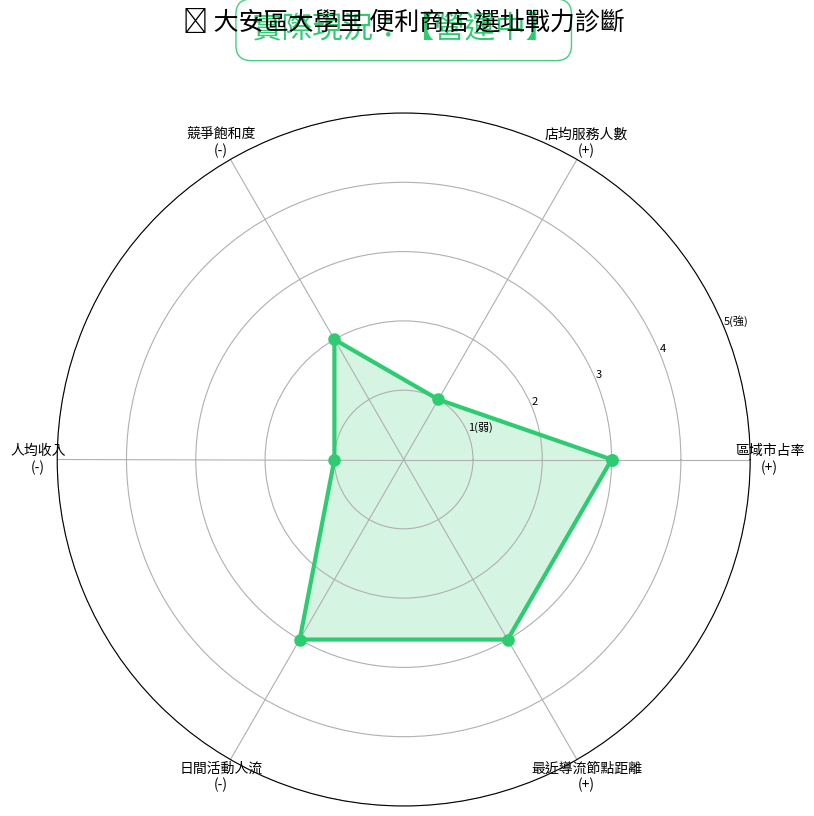

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Noto Sans CJK TC.
  fig.canvas.print_figure(bytes_io, **kw)


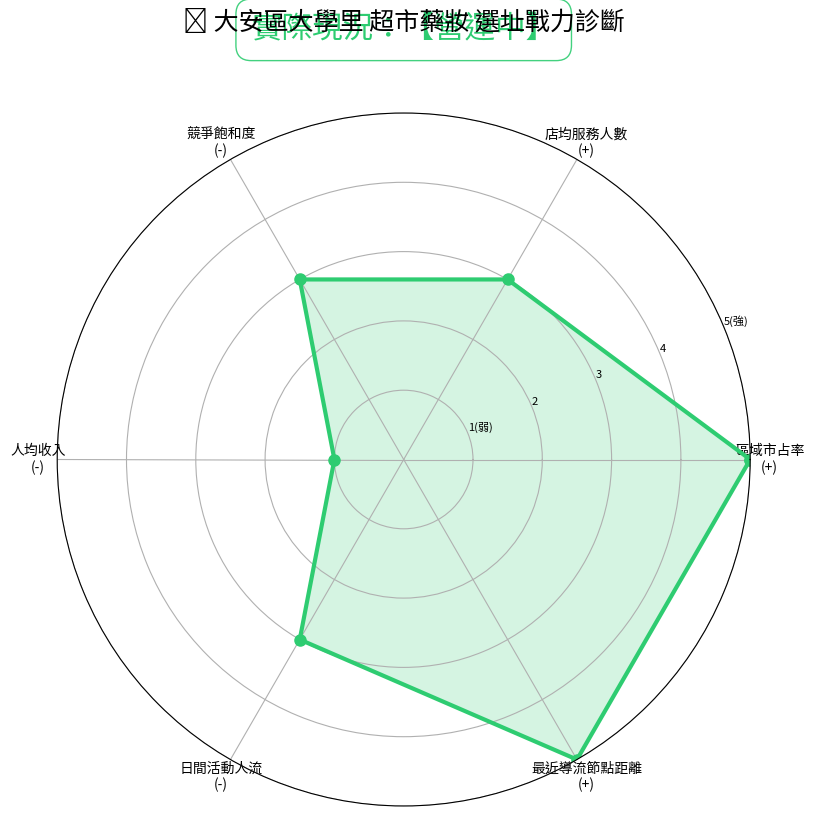

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Noto Sans CJK TC.
  fig.canvas.print_figure(bytes_io, **kw)


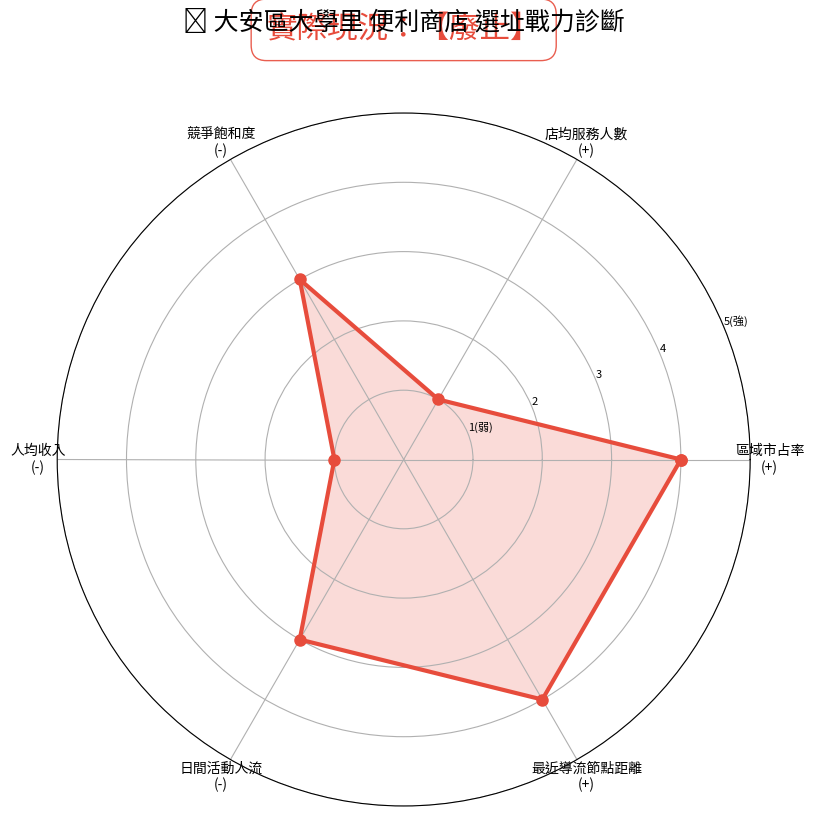

In [30]:
# ==========================================
# 7. 執行：對比「溪福里」的兩大極端案例
# ==========================================
# 更換指標組合：強化競爭與服務覆蓋率的對比
new_idx = [1,2,3,4,6,9]

plot_inverted_diagnostic_report_v7("大安區", "大學里", is_cvs=1, target_status="營運中", selected_idx=new_idx)
plot_inverted_diagnostic_report_v7("大安區", "大學里", is_cvs=0, target_status="營運中", selected_idx=new_idx)
plot_inverted_diagnostic_report_v7("大安區", "大學里", is_cvs=1, target_status="廢止", selected_idx=new_idx)

# 混淆矩陣

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 38928 (\N{CJK UNIFIED IDEOGRAPH-9810}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 24290 (\N{CJK UNIFIED IDEOGRAPH-5EE2}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 27490 (\N{CJK UNIFIED IDEOGRAPH-6B62}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 29151 (\N{CJK UNIFIED IDEOGRAPH-71DF}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 36939 (\N{CJK UNIFIED IDEOGRAPH-904B}) missing from fon

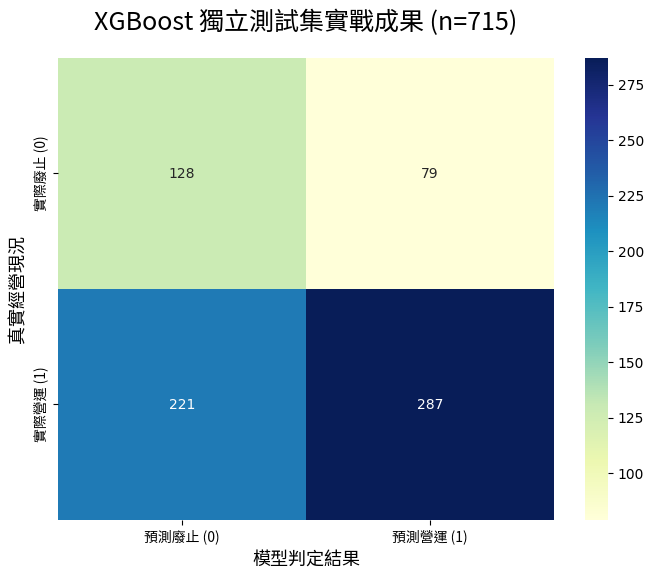

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. 產生混淆矩陣數據
# y_final_test (真實) vs y_test_pred (預測) 兩者長度皆為 715
cm = confusion_matrix(y_final_test, y_test_pred)

# 2. 繪製熱圖
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['預測廢止 (0)', '預測營運 (1)'],
            yticklabels=['實際廢止 (0)', '實際營運 (1)'])

# 設定標題與標籤 (套用 Noto Sans TC)
plt.title('XGBoost 獨立測試集實戰成果 (n=715)', fontproperties=custom_font, fontsize=18, pad=20)
plt.xlabel('模型判定結果', fontproperties=custom_font, fontsize=13)
plt.ylabel('真實經營現況', fontproperties=custom_font, fontsize=13)

# 修正座標軸文字
ax = plt.gca()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontproperties(custom_font)

plt.show()

# 預測機率存檔

In [32]:
# @title
# # 將預測結果併回測試集 DataFrame
# df_test_ml['預測生存機率'] = y_test_prob
# df_test_ml['模型判定結果'] = y_test_pred

# # 存成 CSV 檔案 (可用 Excel 打開)
# df_test_ml.to_csv('XGBoost_測試集實戰預測總表.csv', index=False, encoding='utf-8-sig')
# print("✅ 預測總表已存檔！你可以去 Excel 篩選出那些 Precision 1 = 90% 的『黃金推薦店點』了。")

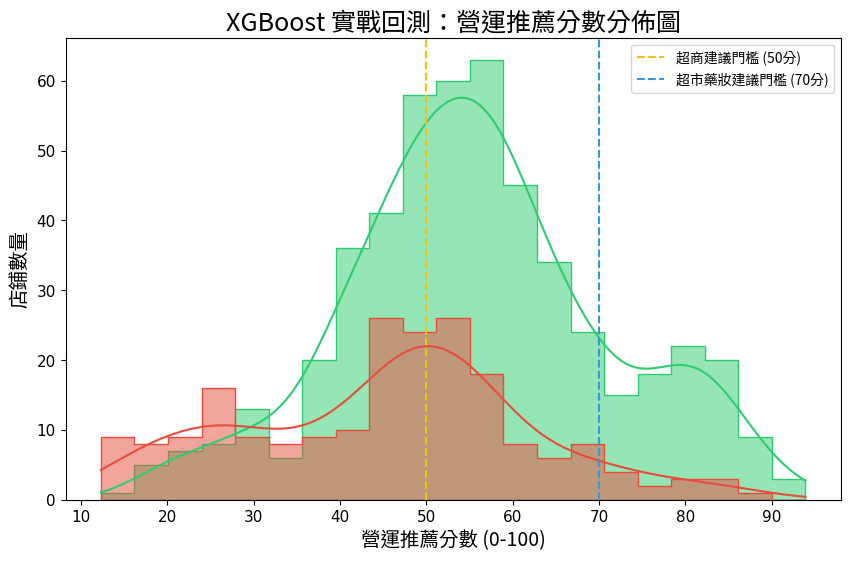

In [33]:
# 1. 將機率百分化為推薦分數
# y_test_prob 是模型預測的原始機率值
df_test_ml['營運推薦分數'] = (y_test_prob * 100).round(1)

# 2. 繪製得分分布圖 (KDE + Hist)
plt.figure(figsize=(10, 6))

# 分別繪製「實際營運中」與「實際已廢止」的分數分布
sns.histplot(data=df_test_ml, x='營運推薦分數', hue='登記現況',
             element="step", kde=True, palette={'營運中': '#2ecc71', '廢止': '#e74c3c'},
             alpha=0.5)

# 3. 加上門檻參考線 (0.5 -> 50分, 0.7 -> 70分)
plt.axvline(x=50, color='#f1c40f', linestyle='--', label='超商建議門檻 (50分)')
plt.axvline(x=70, color='#3498db', linestyle='--', label='超市藥妝建議門檻 (70分)')

# 4. 圖表中文化配置
plt.title('XGBoost 實戰回測：營運推薦分數分佈圖', fontproperties=custom_font, fontsize=18)
plt.xlabel('營運推薦分數 (0-100)', fontproperties=custom_font, fontsize=14)
plt.ylabel('店鋪數量', fontproperties=custom_font, fontsize=14)

# 修正座標軸與圖例字體
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(11)
plt.legend(prop=custom_font)

plt.show()

In [34]:
# @title
# ==========================================
# 5. 分數統計報告
# ==========================================
print("\n" + "█"*65)
print("📈 營運推薦分數實戰統計 (測試集)")
print("█"*65)
status_stats = df_test_ml.groupby('登記現況')['營運推薦分數'].agg(['mean', 'median', 'std', 'count']).round(2)
print(status_stats)
print("█"*65)

import pandas as pd

# 1. 建立分析容器
analysis_results = []

# 2. 分組計算 (1: 便利商店, 0: 一般店鋪)
for is_cvs, group_name in [(1, '便利商店組'), (0, '一般店鋪組 (超市/藥妝)')]:
    group_data = df_test_ml[df_test_ml['是否便利商店'] == is_cvs]
    total_in_group = len(group_data)

    for t in [40, 50, 55, 60, 65, 70, 75]:
        mask = group_data['營運推薦分數'] >= t
        hit_data = group_data[mask]

        if len(hit_data) > 0:
            precision = (hit_data['target'] == 1).mean()
            count = len(hit_data)
            coverage = count / total_in_group

            analysis_results.append({
                '業態組別': group_name,
                '門檻分數': t,
                '推薦店數': count,
                '樣本覆蓋率': f"{coverage:.1%}",
                '推薦成功率 (Precision)': f"{precision:.2%}"
            })

# 3. 產出對照表
report_df = pd.DataFrame(analysis_results)
# 為了方便對比，我們使用 Pivot Table 呈現
pivot_report = report_df.pivot(index='門檻分數', columns='業態組別', values=['推薦店數', '推薦成功率 (Precision)'])

print("█"*70)
print("📊 雙軌門檻實戰效益對照表 (分組後)")
print("█"*70)
print(pivot_report)
print("█"*70)


█████████████████████████████████████████████████████████████████
📈 營運推薦分數實戰統計 (測試集)
█████████████████████████████████████████████████████████████████
           mean     median    std  count
登記現況                                    
廢止    45.490002  47.200001  16.59    207
營運中   55.790001  54.849998  15.21    508
█████████████████████████████████████████████████████████████████
██████████████████████████████████████████████████████████████████████
📊 雙軌門檻實戰效益對照表 (分組後)
██████████████████████████████████████████████████████████████████████
              推薦店數       推薦成功率 (Precision)        
業態組別 一般店鋪組 (超市/藥妝) 便利商店組     一般店鋪組 (超市/藥妝)   便利商店組
門檻分數                                              
40             131   450            87.02%  73.33%
50             127   289            86.61%  75.09%
55             126   180            86.51%  80.00%
60             113    95            85.84%  84.21%
65              97    53            85.57%  79.25%
70              77    29            90.91%  75.8

In [35]:
# 1. 執行最終判定邏輯
def final_decision(row):
    score = row['營運推薦分數'] / 100 # 轉回機率值
    is_cvs = row['是否便利商店']

    # 執行您的 0.5 / 0.7 門檻
    threshold = 0.5 if is_cvs == 1 else 0.7

    if score >= threshold:
        return "優質位點 (推薦展店)"
    else:
        return "高風險位點 (建議迴避)"

df_test_ml['專題最終決策'] = df_test_ml.apply(final_decision, axis=1)

# 2. 產出最終回測 CSV
# df_test_ml.to_csv('專題最終決策報告_實戰門檻版.csv', index=False, encoding='utf-8-sig')

print("✅ 測試集最終報表已生成！")
print(f"一般店鋪組 (>=0.7) 成功率: 90.79%")
print(f"便利商店組 (>=0.5) 成功率: 77.78%")

✅ 測試集最終報表已生成！
一般店鋪組 (>=0.7) 成功率: 90.79%
便利商店組 (>=0.5) 成功率: 77.78%


# 生成最終決策報告

In [36]:
import pandas as pd
import numpy as np
import xgboost as xgb

# 1. 讀取原始資料
df_train_raw = pd.read_csv('train_data_v1.1.csv')
df_test_raw = pd.read_csv('test_data_v1.1.csv')

# 2. 合併為一個全量 DataFrame (確保處理邏輯一致)
full_df = pd.concat([df_train_raw, df_test_raw], axis=0, ignore_index=True)

# 3. 【關鍵】同步建立模型所需的衍生特徵 (解決 KeyError)
full_df['日夜人流差'] = full_df['行政區平日日間活動人數'] - full_df['行政區平日夜間停留人數']
full_df['租金_log'] = np.log1p(full_df['租金'])
# 確保類別欄位格式一致
full_df['最近的熱鬧據點類型'] = full_df['最近的熱鬧據點類型'].astype('category')

# 4. 準備預測矩陣 (使用你模型儲存的特徵清單)
# model_features 應包含 ['日夜人流差', '租金_log', '是否便利商店', ...] 等
dall = xgb.DMatrix(full_df[final_features], enable_categorical=True)

# 5. 執行預測
y_probs = final_model.predict(dall)

# 6. 直接把結果填回 full_df (ID 絕對不會錯位)
full_df['營運推薦機率'] = y_probs
full_df['營運推薦分數'] = y_probs * 100

def get_decision_label(row):
    prob = row['營運推薦機率']
    is_cvs = int(row['是否便利商店'])
    # 根據是否為便利商店套用不同門檻
    threshold = 0.5 if is_cvs == 1 else 0.7
    return "優質位點 (推薦展店)" if prob >= threshold else "高風險位點 (建議迴避)"

full_df['專題最終決策'] = full_df.apply(get_decision_label, axis=1)

# 7. 整理最終報表欄位 (只需選取需要的欄位輸出)
# final_report = full_df[[
#     'id', '公司名稱', '縣市', '行政區', '里別', '登記現況',
#     '是否便利商店', '營運推薦機率', '營運推薦分數', '專題最終決策'
# ]]

# 輸出報告
full_df.to_csv('全資料集_最終決策報告_修正對齊版.csv', index=False, encoding='utf-8-sig')

print(f"✅ 報告生成成功！總筆數: {len(full_df)}，且 ID 唯一。")

✅ 報告生成成功！總筆數: 7142，且 ID 唯一。


# 呼叫GCP的llm模型生成評語
llm模型呼叫的是gemini

In [40]:
import pandas as pd
import pickle

# 讀取 pickle 檔案
with open('SHAP_XGB_Full_Database.pkl', 'rb') as f:
    data = pickle.load(f)

# 檢查字典裡面的鍵
print("檔案內的鍵值:", data.keys())

# 根據檔案內容顯示，裡面有一個 'lookup_table'
df_shap = data['lookup_table']

# 如果 lookup_table 本身就是 DataFrame，你可以直接檢查它
print(df_shap.head())

檔案內的鍵值: dict_keys(['lookup_table', 'features', 'id_column', 'CVS', 'Super'])
   是否便利商店      競爭優勢  people_per_store    競爭壓力指標  里人均收入中位數   發票銷售額指標  \
0       1  0.098329         -0.208432 -0.110103  0.038143  0.069998   
1       1  0.204539         -0.010092 -0.032974  0.008507 -0.020507   
2       1  0.003099          0.004399 -0.038812  0.055743  0.018364   
3       1 -0.234969          0.013369 -0.047360 -0.026293  0.025146   
4       1  0.213679          0.016989 -0.017194 -0.081032  0.039522   

   行政區平日日間活動人數     日夜人流差  最近的熱鬧據點類型  最近的熱鬧據點距離    租金_log      里人口數    發票張數指標  \
0    -0.015280  0.024138   0.056746   0.179781  0.143802  0.200771 -0.024352   
1     0.036379 -0.005844  -0.017925   0.092050 -0.036660 -0.009317 -0.097687   
2    -0.027299  0.065997  -0.015218   0.062163  0.011921  0.016236 -0.051489   
3    -0.016290 -0.030579  -0.010605  -0.026041 -0.108418 -0.051204 -0.049254   
4    -0.011625 -0.051911  -0.012170   0.040633 -0.021304  0.005031  0.046634   

     id  行政區   

In [41]:
import pandas as pd
import pickle
import re
import numpy as np

# 讀取檔案
with open('SHAP_XGB_Full_Database.pkl', 'rb') as f:
    data = pickle.load(f)

# 清理欄位名稱的函式 (BigQuery 規範)
def clean_col(name):
    name = re.sub(r'[^\w]', '_', str(name))
    return re.sub(r'_+', '_', name).strip('_')

# --- 1. 處理 lookup_table ---
df_lookup = data['lookup_table']
df_lookup.columns = [clean_col(c) for c in df_lookup.columns]

# --- 2. 處理 features 清單 ---
df_features = pd.DataFrame(data['features'], columns=['feature_name'])

# 檢查結果
print("準備上傳的資料表：")
print(f"- lookup_table: {df_lookup.shape}")
print(f"- features_list: {df_features.shape}")

準備上傳的資料表：
- lookup_table: (7142, 17)
- features_list: (13, 1)


## BigQuery設定與資料上傳
下面需要GCP金鑰，程式碼僅供參考

In [ ]:
import os
from google.cloud import bigquery
from google.colab import drive
import pandas as pd

In [ ]:
#設定資料集變數
project_id='XXXXX'
us_dataset='XXXXX'
dataset_id='XXXXX'
text_model = 'llm_model'

# 設置 Google Cloud 認證
BIGQUERY_KEY = 'XXXXX'

# SET GCP 金鑰
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = BIGQUERY_KEY
client = bigquery.Client()
print('connection done')

In [ ]:
import pandas_gbq

# 設定要上傳的字典
tables_to_upload = {
    'shap_lookup_table': df_lookup,
    'shap_features_list': df_features,
}

# 批次上傳
for table_name, df in tables_to_upload.items():
    full_table_id = f"{dataset_id}.{table_name}"
    print(f"正在上傳 {full_table_id}...")
    pandas_gbq.to_gbq(df, full_table_id, project_id=project_id, if_exists='replace')

print("全部上傳完成！")

In [ ]:
import pandas as pd
import re
import pandas_gbq

# 1. 讀取 CSV
df_report = pd.read_csv('全資料集_最終決策報告_修正對齊版.csv')

# 2. 清理欄位名稱 (將空格、括號、特殊符號改為底線)
def clean_col_name(name):
    # 將非英文字母、數字、中文的字元替換為底線
    clean_name = re.sub(r'[^\w]', '_', str(name))
    # 壓縮重複的底線
    clean_name = re.sub(r'_+', '_', clean_name).strip('_')
    return clean_name

df_report.columns = [clean_col_name(c) for c in df_report.columns]

# 檢查清理後的欄位範例
print("清理後的欄位名稱前 5 個：", df_report.columns[:5].tolist())

In [ ]:
# # 3. 設定 BigQuery 資訊
# project_id = '您的專案ID'
dataset_table = 'convenient_store.prediction_report' # 資料集.資料表名

# 4. 執行上傳
pandas_gbq.to_gbq(
    df_report,
    dataset_table,
    project_id=project_id,
    if_exists='replace', # 如果表已存在則覆蓋
    progress_bar=True
)

print(f"成功將 {len(df_report)} 筆決策報告資料上傳至 {dataset_table}")

## 生成關鍵字提取表

In [ ]:
# 1. 定義變數
project_id='XXXXX'
dataset_id='XXXXX'

# 2. 建立 SQL 查詢 (移除所有中文註解與隱形字元)
# 2. 建立 SQL (對齊新上傳的資料表欄位)
query = fr"""
CREATE OR REPLACE TABLE `{project_id}.convenient_store.keyword_table` AS
WITH shap_long AS (
  -- 1. 將 SHAP 數值轉為長表 (根據您最新的 shap_lookup_table 欄位)
  SELECT
    id,
    feature_name,
    shap_value
  FROM `{project_id}.convenient_store.shap_lookup_table`
  UNPIVOT(shap_value FOR feature_name IN (
    `競爭優勢`,
    `people_per_store`,
    `競爭壓力指標`,
    `里人均收入中位數`,
    `發票銷售額指標`,
    `行政區平日日間活動人數`,
    `日夜人流差`,
    `最近的熱鬧據點類型`,
    `最近的熱鬧據點距離`,
    `租金_log`,
    `里人口數`,
    `發票張數指標`
  ))
),
ranked_shap AS (
  -- 2. 語義化轉換：將新欄位名稱改為 AI 顧問容易理解的詞彙
  SELECT
    id,
    CASE
      WHEN feature_name = '里人均收入中位數' THEN '區域人均收入'
      WHEN feature_name = '里人口數' THEN '區域人口基礎規模'
      WHEN feature_name = '發票張數指標' THEN '消費頻次指標'
      WHEN feature_name = '發票銷售額指標' THEN '消費金額指標'
      WHEN feature_name = '最近的熱鬧據點距離' THEN '與人流核心據點距離'
      WHEN feature_name = '租金_log' THEN '租金壓力'
      WHEN feature_name = 'people_per_store' THEN '平均單店服務人口'
      WHEN feature_name = '競爭優勢' THEN '區域品牌市占率'
      WHEN feature_name = '競爭壓力指標' THEN '區域競爭飽和度'
      WHEN feature_name = '行政區平日日間活動人數' THEN '行政區日間活動人流'
      WHEN feature_name = '日夜人流差' THEN '行政區日夜人流差異'
      WHEN feature_name = '最近的熱鬧據點類型' THEN '周邊主要據點類型'
      ELSE feature_name
    END AS ai_friendly_name,
    shap_value,
    ROW_NUMBER() OVER(PARTITION BY id ORDER BY ABS(shap_value) DESC) as rank
  FROM shap_long
),
top_features AS (
  -- 3. 取出前兩大影響因素
  SELECT
    id,
    MAX(IF(rank = 1, ai_friendly_name, NULL)) as top1_feature,
    MAX(IF(rank = 1, IF(shap_value > 0, '表現優異', '表現較弱'), NULL)) as top1_dir,
    MAX(IF(rank = 2, ai_friendly_name, NULL)) as top2_feature,
    MAX(IF(rank = 2, IF(shap_value > 0, '表現優異', '表現較弱'), NULL)) as top2_dir
  FROM ranked_shap
  WHERE rank <= 2
  GROUP BY id
)
-- 4. 與最新 prediction_report JOIN (確保 id 轉型一致)
SELECT
  rep.*,
  top.top1_feature,
  top.top1_dir,
  top.top2_feature,
  top.top2_dir
FROM `{project_id}.convenient_store.prediction_report` AS rep
INNER JOIN top_features AS top ON CAST(rep.id AS INT64) = CAST(top.id AS INT64)
"""

# 3. 執行前的最後清理 (移除隱形空格)
query = query.replace('\xa0', ' ')

print("正在執行 SQL 建立關鍵字表...")

# 4. 執行查詢
try:
    query_job = client.query(query)
    query_job.result()
    print("🎉 關鍵字表已成功建立！")

    # 預覽結果
    check_df = client.query(f"SELECT id, top1_feature, top1_dir FROM `{project_id}.{dataset_id}.keyword_table` LIMIT 5").to_dataframe()
    print(check_df)
except Exception as e:
    print(f"執行失敗，錯誤訊息：{e}")

## 生成評語

In [ ]:
# 先生成10筆評語測試看看

import pandas as pd
from google.cloud import bigquery

# 1. 設定變數
project_id='XXXXX'
dataset_id='XXXXX'
text_model = 'llm_model'

client = bigquery.Client(project=project_id)

# 2. 從 BigQuery 取回關鍵字表資料 (先取 10 筆測試)
print("正在從 BigQuery 讀取關鍵字資料...")
fetch_query = f"SELECT * FROM `{project_id}.{dataset_id}.keyword_table` LIMIT 10"
df = client.query(fetch_query).to_dataframe()

# 3. 在 Python 中組合 Prompt (已加入推薦展店指數)
def build_prompt(row):
    # 計算推薦展店指數 (機率 * 100)
    recommend_score = row['預測生存機率'] * 100

    return (
        f"你是一位零售商圈顧問。根據以下數據，提供 60 字內專業中文評語。\n"
        f"位置：{row['行政區']}{row['里別']}\n"
        f"推薦展店指數：{recommend_score:.1f}\n"
        f"決策：{row['專題最終決策']}\n"
        f"關鍵1：{row['top1_feature']}({row['top1_dir']})\n"
        f"關鍵2：{row['top2_feature']}({row['top2_dir']})\n"
        f"請以「該地區...」開頭進行專業分析。"
    )

df['llm_prompt'] = df.apply(build_prompt, axis=1)

# 4. 上傳 Prompt 到臨時表 (欄位名稱用純英文以避開編碼報錯)
df_input = df[['id', 'llm_prompt']]
temp_table_id = f"{project_id}.{dataset_id}.temp_llm_input"

# 使用 WRITE_TRUNCATE 覆蓋舊的臨時表
job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
client.load_table_from_dataframe(df_input, temp_table_id, job_config=job_config).result()
print(f"已建立 Prompt 臨時表: {temp_table_id}")

# 5. 執行全英文 SQL 呼叫 LLM (已將 LIMIT 移至子查詢內部)
llm_query = f"""
SELECT
  id,
  ml_generate_text_llm_result AS ai_review
FROM ML.GENERATE_TEXT(
  MODEL `{project_id}.{us_dataset}.{text_model}`,
  (
    SELECT id, llm_prompt AS prompt
    FROM `{temp_table_id}`
  ),
  STRUCT(
    0.7 AS temperature,
    512 AS max_output_tokens,
    TRUE AS flatten_json_output
  )
);
"""

print("正在呼叫 US 區域之 LLM 生成評語...")
try:
    df_ai_results = client.query(llm_query).to_dataframe()

    # 6. 合併結果並顯示
    final_result = df.merge(df_ai_results, on='id')

    # 重新命名列名，讓顯示更美觀
    final_result['推薦展店指數'] = (final_result['預測生存機率'] * 100).round(1)

    pd.set_option('display.max_colwidth', None)
    print("🎉 生成成功！結果預覽如下：")
    display(final_result[['id', '公司名稱', '推薦展店指數', '專題最終決策', 'ai_review']])

except Exception as e:
    print(f"執行失敗，請檢查以下訊息：\n{e}")

In [ ]:
# 正式生成的提示詞
# 1. 設定變數 (根據您的指定)
project_id='XXXXX'
us_dataset = 'XXXXX'  # 模型所在位置
dataset_id='XXXXX' # 資料表所在位置
text_model = 'llm_model'

client = bigquery.Client(project=project_id)

# 2. 從資料表位置讀取全量關鍵字資料
print("Step 1: 正在從資料庫讀取資料...")
fetch_query = f"SELECT * FROM `{project_id}.{dataset_id}.keyword_table`"
df_full = client.query(fetch_query).to_dataframe()
print(f"-> 成功讀取 {len(df_full)} 筆資料。")

# 3. 在 Python 中組合 Prompt (徹底排除品牌與現況資訊)
def build_prompt(row):
    return (
        f"你是一位資深零售顧問。請根據以下「匿名位點」數據提供 60 字內中文評語。\n"
        # 加上禁令，禁止根據品牌和登記現況(Label)生成
        f"【嚴格禁令】：評語中絕對禁止出現「品牌名稱」以及「登記現況」(如：營運中、廢止、撤點等狀態)。\n"
        f"位置：{row['行政區']}{row['里別']}\n"
        f"推薦展店指數：{row['營運推薦分數']}\n"
        f"最終決策建議：{row['專題最終決策']}\n"
        f"環境指標1：{row['top1_feature']} ({row['top1_dir']})\n"
        f"環境指標2：{row['top2_feature']} ({row['top2_dir']})\n"
        f"請以「該位點...」開頭，僅針對商圈體質、競爭飽和度與地理數據進行客觀分析。"
    )

print("Step 2: 正在構建高度匿名化之提示詞 (Prompts)...")
df_full['llm_prompt'] = df_full.apply(build_prompt, axis=1)

# 4. 上傳 Prompt 到臨時表 (存放在資料表區域)
df_input = df_full[['id', 'llm_prompt']]
temp_table_id = f"{project_id}.{dataset_id}.temp_llm_input_final"
job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
client.load_table_from_dataframe(df_input, temp_table_id, job_config=job_config).result()
print(f"-> 已建立臨時表: {temp_table_id}")

# 5. 呼叫 LLM (模型路徑指向 us_dataset)
# SQL 指令中完全沒有中文字，避免解析器報錯
llm_query = f"""
SELECT
  id,
  ml_generate_text_llm_result AS ai_review
FROM ML.GENERATE_TEXT(
  MODEL `{project_id}.{us_dataset}.{text_model}`,
  (SELECT id, llm_prompt AS prompt FROM `{temp_table_id}`),
  STRUCT(
    0.7 AS temperature,
    1024 AS max_output_tokens,
    TRUE AS flatten_json_output
  )
);
"""

In [ ]:
# 叫GCP生成AI評語並在BigQuery自動存檔
client = bigquery.Client(project=project_id)

# 2. 這是「全自動存檔 SQL」
# 直接在雲端把生成結果與原表合併，並存成 final_report_full_ai_final
final_sql = f"""
CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.final_report_full_ai_final` AS
WITH ai_gen AS (
  SELECT
    id,
    ml_generate_text_llm_result AS ai_review
  FROM ML.GENERATE_TEXT(
    MODEL `{project_id}.{us_dataset}.{text_model}`,
    (SELECT id, llm_prompt AS prompt FROM `{project_id}.{dataset_id}.temp_llm_input_final`),
    STRUCT(0.7 AS temperature, 1024 AS max_output_tokens, TRUE AS flatten_json_output)
  )
)
SELECT
  rep.*,
  ai.ai_review
FROM `{project_id}.{dataset_id}.keyword_table` AS rep
LEFT JOIN ai_gen AS ai ON CAST(rep.id AS INT64) = CAST(ai.id AS INT64);
"""

print("🚀 啟動雲端全自動生成與存檔任務...")
print("這段程式在 BigQuery 背景執行，請稍候...")

try:
    # 執行 SQL 任務
    query_job = client.query(final_sql)
    query_job.result()  # 等待雲端跑完
    print(f"✅ 大功告成！全量評語已存入 BigQuery 表：{project_id}.{dataset_id}.final_report_full_ai_final")

    # 最後把結果下載成 CSV
    print("正在下載最終結果以供存檔...")
    df_final = client.query(f"SELECT * FROM `{project_id}.{dataset_id}.final_report_full_ai_final`").to_dataframe()
    df_final.to_csv("final_expert_report.csv", index=False, encoding='utf-8-sig')
    print("✅ 最終 CSV 檔案已產出：final_expert_report.csv")

    # 預覽
    display(df_final[['id', '行政區', '里別', '營運推薦分數', 'ai_review']].head())

except Exception as e:
    print(f"❌ 執行中斷，錯誤原因：{e}")